In [1]:
import os, sys
if 'ipykernel' in sys.argv[0]:
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:90% !important; }</style>"))
    get_ipython().magic('load_ext sparkver')
    get_ipython().magic('sparkver')

Spark version selected: 2.4.7_2.12, py4j version selected: 0.10.7


In [2]:
APP_NAME = 'piekny notebook'
QUEUE = 'ads_data'
EXECUTOR_MEMORY = '8g'
EXECUTOR_OVERHEAD = 2048
EXECUTOR_CORES = 8
EXECUTORS = 50
DRIVER_MEMORY = '8g'

from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from time import time, strftime
from datetime import datetime, timedelta
import datetime
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark import StorageLevel

spark = (SparkSession.builder
    .appName(APP_NAME)
    .config('spark.yarn.queue', QUEUE)
    .config('spark.executor.memory', EXECUTOR_MEMORY)
    .config('spark.executor.cores', EXECUTOR_CORES)
    .config('spark.dynamicAllocation.enabled','true')
    .config('spark.dynamicAllocation.initialExecutors', 8)
    .config('spark.dynamicAllocation.minExecutors', 1)
    .config('spark.dynamicAllocation.maxExecutors', EXECUTORS)
    .config('spark.dynamicAllocation.schedulerBacklogTimeout', '3s')
    .config('spark.dynamicAllocation.executorIdleTimeout', '120s')
    .config('spark.shuffle.service.enabled','true')
    .config('spark.shuffle.service.port', 7337)
    .config('spark.yarn.executor.memoryOverhead', EXECUTOR_OVERHEAD)
    .config('spark.yarn.appMasterEnv.JAVA_HOME', '/opt/jre1.8.0')
    .config('spark.executorEnv.JAVA_HOME', '/opt/jre1.8.0')
    .config('spark.speculation', 'true')
    .config('spark.driver.memory', DRIVER_MEMORY)
    .config('spark.driver.maxResultSize', '20g')
    .enableHiveSupport()
    .getOrCreate())
print('Application master: http://rm.hadoop.qxlint:8088/proxy/%s' % spark.sparkContext.applicationId)


Application master: http://rm.hadoop.qxlint:8088/proxy/application_1631340653096_556028


In [3]:
import pandas as pd
import numpy as np

In [4]:
import requests
print(pd.__version__)

0.21.1


In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure



%matplotlib inline

In [6]:
yest=(datetime.datetime.now()+timedelta(days=-1)).strftime("%Y-%m-%d")

In [44]:
fromDate = (datetime.datetime.now()+timedelta(days=-7)).strftime("%Y-%m-%d")
toDate = (datetime.datetime.now()+timedelta(days=-1)).strftime("%Y-%m-%d")

In [75]:
print(fromDate, toDate)

2021-09-16 2021-09-22


In [45]:
pd.set_option('display.max_colwidth', 99999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [47]:
premium_views = (spark.table('datahub.pl_allegro_advertising_ppc_insights_premium_view')
                 .where(col('dt').between(fromDate, toDate))
                 .groupBy(round(col('effective_cpm'), 0).alias('cpm_rounded'))
                 .agg(count('*').alias('cnt'))
                 .sort(col('cpm_rounded').asc())
                )

In [48]:
df_pandas = premium_views.toPandas()

In [49]:
df_pandas['cnt'].sum()

77240202

In [50]:
df_pandas['cnt_sum'] = df_pandas['cnt'].cumsum()/df_pandas['cnt'].sum()

In [51]:
df_pandas.head(20)

,cpm_rounded,cnt,cnt_sum
0,0.000,448025,0.006
1,9.000,36911565,0.484
2,10.000,3451943,0.528
3,11.000,3989284,0.580
4,12.000,6520642,0.664
5,13.000,3340762,0.708
6,14.000,3078453,0.748
7,15.000,3296002,0.790
8,16.000,1971790,0.816
9,17.000,1813071,0.839


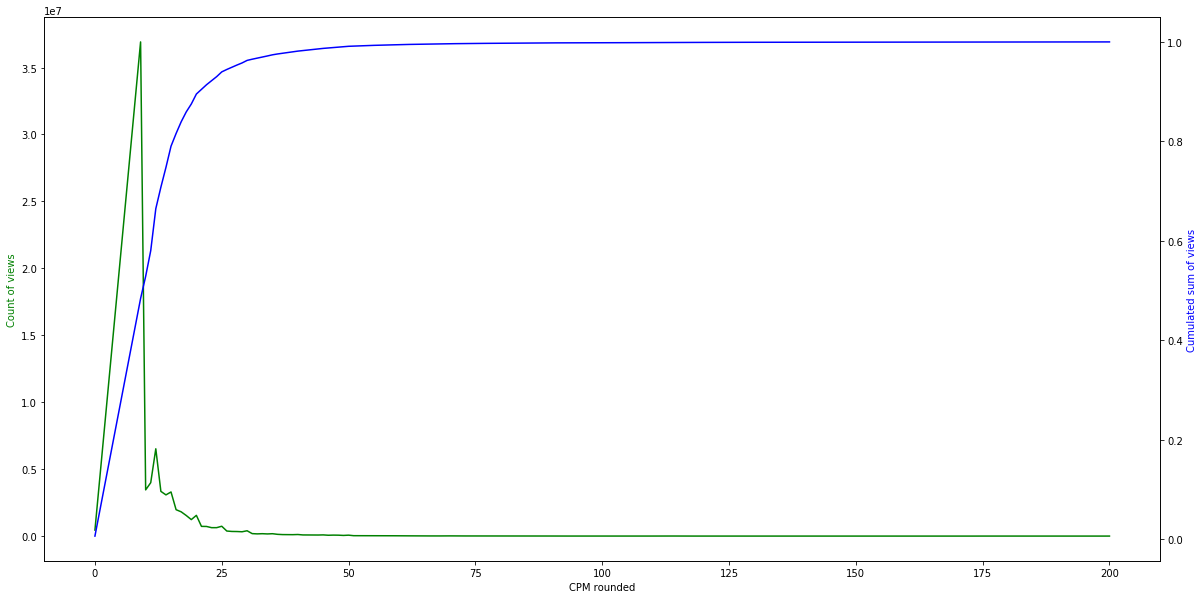

In [52]:
# x = df_pandas['cnt']
# x.plot()

# plt.plot('cpm_rounded', 'cnt', data=df_pandas)
# secax = plt.plot.secondary_axis('cpm_rounded', 'cnt', data=df_pandas)

# plt.plot('cpm_rounded', 'cnt_sum', data=df_pandas)
# plt.figure(figsize=(19, 13), dpi=80)
fig, ax1 = plt.subplots(figsize=(20, 10))

ax2 = ax1.twinx()
ax1.plot('cpm_rounded', 'cnt', data=df_pandas, color='g')
ax2.plot('cpm_rounded', 'cnt_sum', data=df_pandas, color = 'b')

ax1.set_xlabel('CPM rounded')
ax1.set_ylabel('Count of views', color='g')
ax2.set_ylabel('Cumulated sum of views', color='b')


plt.show()

In [53]:
premium_views_placement = (spark.table('datahub.pl_allegro_advertising_ppc_insights_premium_view')
                           .where(col('dt').between(fromDate, toDate))
                           .withColumn('placement_grouped'
                                       , when(col('placement').like('%listing%'), 'listing').otherwise(
                                           when(col('placement').like('%showitem%'), 'showitem').otherwise(
                                            when(col('placement').like('%leftpanel%'), 'leftpanel').otherwise("other")
                                       )
                                      )
                                      )
                           .groupBy(round(col('effective_cpm'), 0).alias('cpm_rounded'))
                           .pivot('placement_grouped')
                           .agg(count('*').alias('cnt'))
                           .sort(col('cpm_rounded').asc())
                          )

In [54]:
premium_views_placement_pandas = premium_views_placement.toPandas()

In [55]:
premium_views_placement_pandas['leftpanel_sum'] = premium_views_placement_pandas['leftpanel'].cumsum()/premium_views_placement_pandas['leftpanel'].sum()
premium_views_placement_pandas['listing_sum'] = premium_views_placement_pandas['listing'].cumsum()/premium_views_placement_pandas['listing'].sum()
premium_views_placement_pandas['showitem_sum'] = premium_views_placement_pandas['showitem'].cumsum()/premium_views_placement_pandas['showitem'].sum()

In [66]:
lf_ratio = (premium_views_placement_pandas['leftpanel'].sum()/
            (premium_views_placement_pandas['leftpanel'].sum() + 
             premium_views_placement_pandas['listing'].sum() + 
             premium_views_placement_pandas['showitem'].sum())
           )

lf_ratio

0.23012817858762202

In [67]:
li_ratio = (premium_views_placement_pandas['listing'].sum()/
            (premium_views_placement_pandas['leftpanel'].sum() + 
             premium_views_placement_pandas['listing'].sum() + 
             premium_views_placement_pandas['showitem'].sum())
           )

li_ratio

0.69829443221808252

In [68]:
si_ratio = (premium_views_placement_pandas['showitem'].sum()
            /(premium_views_placement_pandas['leftpanel'].sum() +
              premium_views_placement_pandas['listing'].sum() + 
              premium_views_placement_pandas['showitem'].sum())
           )

si_ratio

0.071577389194295474

In [71]:
lf_min_cpm = premium_views_placement_pandas['leftpanel_sum'][1]
li_min_cpm = premium_views_placement_pandas['listing_sum'][1]
si_min_cpm = premium_views_placement_pandas['showitem_sum'][1]

In [72]:
lf_ratio * lf_min_cpm

0.065536182828729528

In [73]:
li_ratio * li_min_cpm

0.38787201773501323

In [74]:
si_ratio * si_min_cpm

0.030272435072088495

In [56]:
premium_views_placement_pandas.head(20)
## leftpanel ma najmniej viewsów za cpm 9

,cpm_rounded,leftpanel,listing,showitem,leftpanel_sum,listing_sum,showitem_sum
0,0.000,10902,428814,8309,0.001,0.008,0.002
1,9.000,5051126,29530499,2329940,0.285,0.555,0.423
2,10.000,1035952,2154339,261652,0.343,0.595,0.470
3,11.000,1173145,2556539,259600,0.409,0.643,0.517
4,12.000,1805439,4208974,506229,0.511,0.721,0.609
5,13.000,1005123,2060734,274905,0.567,0.759,0.659
6,14.000,985411,1837716,255326,0.623,0.793,0.705
7,15.000,1098949,1928486,268567,0.684,0.829,0.753
8,16.000,670402,1114077,187311,0.722,0.850,0.787
9,17.000,620476,1042377,150218,0.757,0.869,0.814


In [57]:
premium_views_device = (spark.table('datahub.pl_allegro_advertising_ppc_insights_premium_view')
                           .where(col('dt').between(fromDate, toDate))
                           .withColumn('placement_grouped'
                                       , when(col('placement').like('%desktop%'), 'desktop').otherwise(
                                           when(col('placement').like('%mobile%'), 'rwd').otherwise(
                                            when(col('placement').like('%ios%'), 'ios').otherwise(
                                                when(col('placement').like('%android%'), 'android').otherwise("other")
                                       )
                                      )
                                      )
                                      )
                           .groupBy(round(col('effective_cpm'), 0).alias('cpm_rounded'))
                           .pivot('placement_grouped')
                           .agg(count('*').alias('cnt'))
                           .sort(col('cpm_rounded').asc())
                          )

In [58]:
premium_views_device_pandas = premium_views_device.toPandas()

In [59]:
premium_views_device_pandas['desktop_sum'] = premium_views_device_pandas['desktop'].cumsum()/premium_views_device_pandas['desktop'].sum()
premium_views_device_pandas['rwd_sum'] = premium_views_device_pandas['rwd'].cumsum()/premium_views_device_pandas['rwd'].sum()
premium_views_device_pandas['ios_sum'] = premium_views_device_pandas['ios'].cumsum()/premium_views_device_pandas['ios'].sum()
premium_views_device_pandas['android_sum'] = premium_views_device_pandas['android'].cumsum()/premium_views_device_pandas['android'].sum()

In [60]:
premium_views_device_pandas.head(20)
## rozklad po urządzeniach jest bardzo zbliżony do siebie

,cpm_rounded,android,desktop,ios,other,rwd,desktop_sum,rwd_sum,ios_sum,android_sum
0,0.000,151229,127684,47385,10902,110825,0.006,0.008,0.011,0.007
1,9.000,11102289,10511905,2515899,5051126,7730346,0.528,0.539,0.591,0.551
2,10.000,820288,812824,180064,1035952,602815,0.568,0.580,0.632,0.592
3,11.000,1023902,933603,201507,1173145,657127,0.614,0.625,0.679,0.642
4,12.000,1652970,1578369,293215,1805439,1190649,0.693,0.707,0.746,0.723
5,13.000,808551,812040,151563,1005123,563485,0.733,0.746,0.781,0.762
6,14.000,708562,718530,147685,985411,518265,0.769,0.781,0.815,0.797
7,15.000,702373,803269,134145,1098949,557266,0.808,0.820,0.846,0.831
8,16.000,432989,453533,82046,670402,332820,0.831,0.843,0.865,0.853
9,17.000,410741,395331,83562,620476,302961,0.850,0.863,0.884,0.873
